# **Multiple Object Tracking with PyTorch**

---
**Reference**

*   Object Detection with Faster R-CNN: https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/
*   OpenPose: Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields : https://arxiv.org/abs/1812.08008
*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking: https://arxiv.org/abs/1602.00763


**Goals**


1. We will use our Ataxia Dataset,
2. First part: Object Detection with **Faster R-CNN**,
3. Second part: Extract keypoints using **OpenPose**,
4. Third part: Multiple Object(ID) Tracking with  **Simple Online and Realtime Tracking (SORT)** algorithm.

---
Most of this code is from [here](https://github.com/ROC-HCI/Automated-Ataxia-Gait).

## 0. Preparation
*   You need to mount your drive and create a folder named `ataxia_dataset/` with all the videos (in mp4 format).
---






In [ ]:
root = '/content/drive'
from google.colab import drive
drive.mount(root)

Mounted at /content/drive


In [ ]:
# Making Directory

import os
from os.path import join

frames_path = "/content/frames/"
!mkdir "{frames_path}"

## 1. Extract frames using `ffmpeg`
*   We will extract frames from all videos at 30 fps and store them temporarily on CoLab.
---

In [ ]:
import subprocess
from tqdm import tqdm

raw_videos_path = "/content/drive/MyDrive/ataxia_dataset/"

for video in tqdm(os.listdir(raw_videos_path)): # Extract frames for all videos & save them
  if ".mp4" not in video: # ignore other files if present in the directory
    continue
  else:
    if os.path.exists(os.path.join(frames_path, f"{int(video[:-4]):03}")): # int(video[:-4]) => 1.mp4 is converted to 1 & the :03 makes sure that each video is xxx and thus sorted by definition
      continue
    os.mkdir(os.path.join(frames_path, f"{int(video[:-4]):03}"))
    command = ["ffmpeg", "-i", os.path.join(raw_videos_path, video), "-vf", "fps=30", os.path.join(frames_path, f"{int(video[:-4]):03}", "output_%03d.jpg")] # Break the video into frames at 30 fps
    out = subprocess.run(command, stderr=subprocess.PIPE)

100%|██████████| 178/178 [06:36<00:00,  2.23s/it]


In [ ]:
import sys

person0_data = join(frames_path, '000')
sys.path.append(person0_data)

/content/frames/000/output_001.jpg


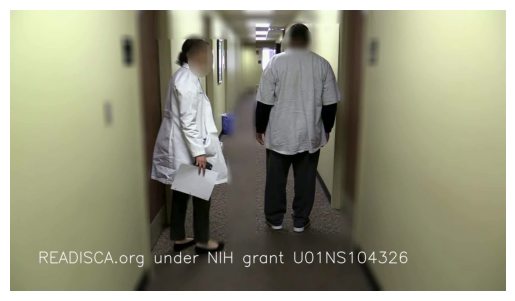

In [ ]:
# Example: Original picture before detection

import cv2
import matplotlib.pylab as plt

list_person0_data = os.listdir(person0_data)
list_person0_data.sort()

print(join(person0_data, list_person0_data[0]))
img_ex_path = join(person0_data, list_person0_data[0])
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()

---
## 2. Object Detection with Faster R-CNN

*  We will use a pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.
---

In [ ]:
# Import required packages/modules first
import torch
import torchvision
from torchvision import transforms as T

import numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device) #cuda speeds up by ~8x
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 140MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
# example prediction

import time
threshold = 0.8

img = Image.open(img_ex_path) # Load the image
transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
img = transform(img).to(device) # Apply the transform to the image
start = time.time()
pred = model([img]) # Pass the image to the model
end = time.time()
print(end - start)

2.126133918762207


In [ ]:
img.shape

torch.Size([3, 1088, 1920])

In [ ]:
pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())] # Get the Prediction Score
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())] # Bounding boxes
pred_score = list(pred[0]['scores'].detach().cpu().numpy())
pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
pred_boxes = pred_boxes[:pred_t+1]
pred_class = pred_class[:pred_t+1]
pred_class

['person', 'person']

In [ ]:
# Thus, Define a function for get a prediction result from the model

def get_prediction(img_path, threshold):
  img = Image.open(img_path).convert('RGB') # Load the image
  img = transform(img).to(device) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model

  mask = (pred[0]['labels'] == 1) & (pred[0]['scores'] > threshold) # Mask out to only keep people and confidence > threshold
  boxes = pred[0]['boxes'][mask]
  labels = pred[0]['labels'][mask]
  scores = pred[0]['scores'][mask]

  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(labels.cpu().numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(boxes.detach().cpu().numpy().astype(np.int32))] # Bounding boxes, the type conversion to np.int32 is necessary for cv2
  pred_score = list(scores.detach().cpu().numpy())

  return pred_boxes, pred_class, pred_score

In [ ]:
# Finally Define a function for object display

def object_display_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):

  boxes, pred_cls, _ = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

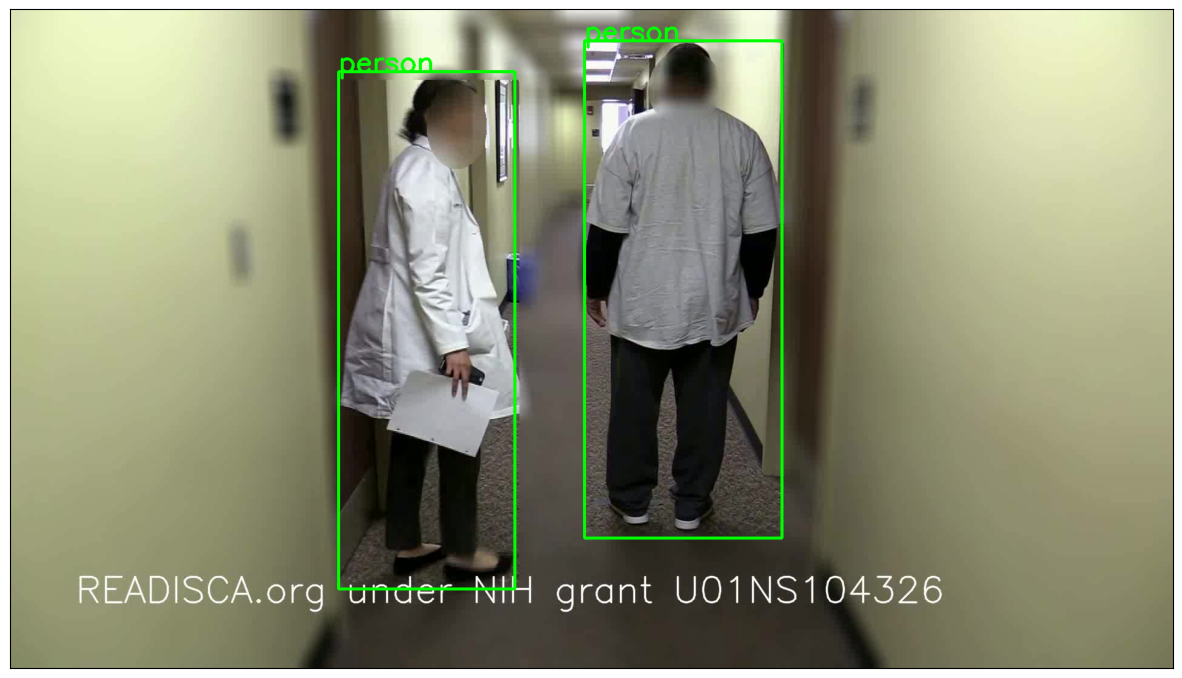

In [ ]:
# Example: After detection
object_display_api(img_ex_path, threshold=0.8)

In [ ]:
# Utility to crop and keep only the object in the frame, only used for the next function
def crop_img(img, box):
  h = int(-box[0][1]+box[1][1]+0.5)
  w = int(-box[0][0]+box[1][0]+0.5)
  y = int(box[0][1]+0.5)
  x = int(box[0][0]+0.5)
  b = int(0.02*h)
  cropped_img = img[max(0,y-b):min(y+h+b, len(img)), max(0,x-b):min(x+w+b, len(img[0]))]
  return cropped_img

In [ ]:
# Object detection but only Person class
def show_person(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):

  boxes, pred_cls, _ = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    if pred_cls[i] == 'person':
      break
  cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
  print(boxes[i])
  cropped_img = crop_img(img, boxes[i])
  plt.figure(figsize=(5,7)) # display the output image
  plt.imshow(cropped_img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

[(948, 52), (1274, 873)]


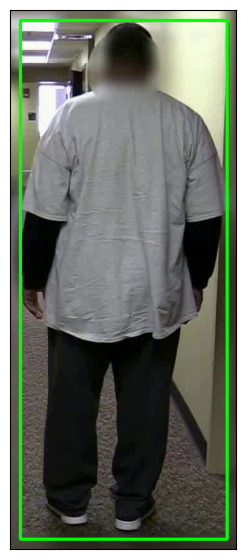

In [ ]:
show_person(img_ex_path, threshold=0.8)

*   The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
*   Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
*   We need a prediction result (bbs offset, class label, pred scores) for all the images.

In [ ]:
import json

jsons_path = '/content/jsons'
os.mkdir(jsons_path)

In [ ]:
# Extract bboxes, labels and scores and store as a json in proper format
# Format from - https://github.com/mlvlab/COSE474/blob/master/3_MOT_detinfo.json

for video in tqdm(sorted(os.listdir(frames_path))):
  person_data = join(frames_path, video)
  person_json = {}

  data_list = os.listdir(person_data)
  data_list.sort()

  for frame in data_list:
    cur_frame = join(frames_path, video, frame)
    pred_boxes, pred_class, pred_score = get_prediction(cur_frame, 0.9)
    data_list = [{"bbox": [int(bbox[0][0]), int(bbox[0][1]), int(bbox[1][0]), int(bbox[1][1])],
                  "labels": 1, # label will always be 1 as we are only detecting people.
                  "scores": float(score)} for bbox, score in zip(pred_boxes, pred_score)]
    person_json[frame] = data_list

  f = open(join(jsons_path, video + ".json"), "w")
  json.dump(person_json, f, indent=4)
  f.close()

100%|██████████| 149/149 [1:12:37<00:00, 29.24s/it]


Download the `/content/jsons` in case the CoLab runtime expires.

In [ ]:
!zip -r ovr_jsons.zip /content/jsons

  adding: content/jsons/ (stored 0%)
  adding: content/jsons/126.json (deflated 90%)
  adding: content/jsons/148.json (deflated 91%)
  adding: content/jsons/076.json (deflated 90%)
  adding: content/jsons/119.json (deflated 91%)
  adding: content/jsons/130.json (deflated 91%)
  adding: content/jsons/093.json (deflated 91%)
  adding: content/jsons/103.json (deflated 90%)
  adding: content/jsons/147.json (deflated 90%)
  adding: content/jsons/140.json (deflated 91%)
  adding: content/jsons/096.json (deflated 90%)
  adding: content/jsons/133.json (deflated 91%)
  adding: content/jsons/089.json (deflated 90%)
  adding: content/jsons/121.json (deflated 91%)
  adding: content/jsons/060.json (deflated 90%)
  adding: content/jsons/131.json (deflated 90%)
  adding: content/jsons/139.json (deflated 91%)
  adding: content/jsons/078.json (deflated 90%)
  adding: content/jsons/151.json (deflated 90%)
  adding: content/jsons/145.json (deflated 90%)
  adding: content/jsons/127.json (deflated 90%)
  a

## 3. KeyPoint extraction using OpenPose
*   Now we will extract keypoints from all the frames using OpenPose, and store these as well.
---

### Path Settings

In [ ]:
OPENPOSE_PATH="./openpose/"
HOME_PATH='./'

### Installing OpenPose

In [ ]:
#@title
from os.path import exists, join, basename, splitext

# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote

!wget "https://drive.usercontent.google.com/download?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download&authuser=0&confirm=t&uuid=50355e54-0445-4875-9d0e-3866a1f6239d&at=APZUnTVA3sHsK5rk-u2O6phIms2L%3A1711987634035" -O models.zip

!unzip models.zip -d openpose

Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to un

In [ ]:
!sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
!sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
!sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
!sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
!sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
!sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
!sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
!sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
!sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
!sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
!sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
!sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt

### Make (takes \~ 10 minutes!)

In [ ]:
!cd openpose && rm -rf build || true && mkdir build

In [ ]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file
!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file

In [ ]:
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "12.2") 
-- Building with CUDA.
-- CUDA detected: 12.2
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

### Make the build executable

In [ ]:
!cd $OPENPOSE_PATH && chmod -R 755 './build/'

### Extract keypoints

In [ ]:
keypoints_path = "/content/keypoints/"
os.mkdir(keypoints_path)

In [ ]:
# Using these frames,
for video in tqdm(os.listdir(frames_path)):
  if ".mp4" not in video:
    continue
  else:
    # Extract keypoints using openpose
    if os.path.exists(f"/content/{keypoints_path}/{video[:-4]}/"):
      continue
    os.mkdir(f"/content/{keypoints_path}/{video[:-4]}/")
    openposed = ["./build/examples/openpose/openpose.bin",
                 "--image_dir", f"/content/{frames_path}/{video[:-4]}/", \
                 "--number_people_max", "1", \
                 "--write_json", f"/content/{keypoints_path}/{video[:-4]}/", \
                 "--keypoint_scale", "3", \
                 "--display", "0", \
                 "--render_pose", "0", \
                 "--model_pose", "BODY_25",]
    # need to run this from the openpose dir
    openpoze = subprocess.run(openposed, stderr=subprocess.PIPE, stdout=subprocess.PIPE, cwd="/content/openpose")
    print(openpoze.stderr)

100%|██████████| 181/181 [01:34<00:00,  1.91it/s]

b''


## 4. Object ID Tracking with SORT
*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking
---

In [ ]:
# Git clone: SORT Algorithm

!git clone https://github.com/abewley/sort.git

sort_path = '/content/sort/'
sys.path.append(sort_path)

Cloning into 'sort'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 208 (delta 2), reused 2 (delta 1), pack-reused 202
Receiving objects: 100% (208/208), 1.20 MiB | 28.04 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
# requirement for sort
!cd "{sort_path}"; pip install -r requirements.txt
!cd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 42.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=dae536a79cf32f69d37b48fd60117f1d1eafee869625181c4eb55cca4e8080f1
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
  Created wheel for scikit-image: filename=scikit_image-0.17.2-cp310-cp310-linux_x86_64.whl size=33220423 sha256=1670aa0306794a7df0eb5d4585d4d3482aee6c48cd077c00023bee67d52b4541
  Stored in directory: /root/.cache/pip/wheels/30/fc/f4/10c6987c3a9cb937913fa19f8290e91e6f66df2440c2af6130
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628950 sh

In [ ]:
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

# !pip uninstall scikit-image -y
# !pip uninstall imgaug -y
# !pip install imgaug
# !pip install -U scikit-image

import skimage
print(skimage.__version__)

0.17.2


In [ ]:
!export MPLBACKEND=Agg # NOTE TKAgg doesn't work

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

At this point, the next cell will give an error with TKAgg, you must modify the 23rd line in `/content/sort/sort.py` from TKAgg to Agg.

In [ ]:
import json
import collections
from sort import *
from pprint import pprint

example = join(jsons_path, '000.json')

with open(example) as data_file:
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

In [ ]:
# Let's check out downloaded json file
pprint(odata)

OrderedDict([('output_001.jpg',
              [{'bbox': [948, 52, 1274, 873],
                'labels': 1,
                'scores': 0.9997586607933044},
               {'bbox': [542, 103, 833, 957],
                'labels': 1,
                'scores': 0.9978561997413635}]),
             ('output_002.jpg',
              [{'bbox': [951, 51, 1276, 869],
                'labels': 1,
                'scores': 0.999721348285675},
               {'bbox': [543, 103, 842, 949],
                'labels': 1,
                'scores': 0.9955568909645081}]),
             ('output_003.jpg',
              [{'bbox': [952, 50, 1276, 868],
                'labels': 1,
                'scores': 0.9997262358665466},
               {'bbox': [542, 97, 829, 965],
                'labels': 1,
                'scores': 0.9979217648506165}]),
             ('output_004.jpg',
              [{'bbox': [951, 53, 1275, 870],
                'labels': 1,
                'scores': 0.999717652797699},
               



---



*   For each image, bbs offset, class label, pred scores are all annotated.
*   Labels are annotated as a number - not a word, and for further information, go to the website below.
* https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/



---



In [ ]:
# Making new directory for saving results
save_path = '/content/save/'
!mkdir "{save_path}"

In [ ]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

In [ ]:
import math
from google.colab.patches import cv2_imshow

In [ ]:
for vid_path in tqdm(sorted(os.listdir(frames_path))):
  cur_save_path = join(save_path, vid_path)
  os.mkdir(cur_save_path)
  for key in sorted(odata.keys()):
      arrlist = []
      det_img = cv2.imread(os.path.join(frames_path, vid_path, key))
      result = odata[key]

      for info in result:
          bbox = info['bbox']
          labels = info['labels']
          scores = info['scores']
          templist = bbox+[scores]
          arrlist.append(templist) # we always append because we only detect people.

      track_bbs_ids = mot_tracker.update(np.array(arrlist))

      for j in range(track_bbs_ids.shape[0]):
          ele = track_bbs_ids[j, :]
          x = int(ele[0])
          y = int(ele[1])
          x2 = int(ele[2])
          y2 = int(ele[3])
          track_label = str(int(ele[4]))

          # crop each person with x,y,x2,y2
          cropped_img = crop_coordinate(det_img, x, y, x2, y2)
          # identify landmarks
          # make a directory for 'track_label'
          # save if full human visible. discard if width below
          if not os.path.exists(f'{cur_save_path}/' + track_label):
              os.makedirs(f'{cur_save_path}/' + track_label)
          if isinstance(cropped_img, np.ndarray):
            try:
              # save cropped video and landmark data in separate folders
              cv2.imwrite(f'{cur_save_path}/' + track_label + '/per_' + track_label + '_' + key, resize(cropped_img))
            except Exception as e:
              print(f"vid_path: {vid_path}, key: {key}, track_label: {track_label}, error: {e}")
              continue

 18%|█▊        | 27/149 [03:50<17:05,  8.41s/it]

vid_path: 028, key: output_004.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_005.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_006.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_007.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_008.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_009.jpg,

 19%|█▉        | 28/149 [03:53<13:24,  6.65s/it]

vid_path: 028, key: output_167.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_168.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_169.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_170.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_171.jpg, track_label: 29, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 028, key: output_172.jpg,

 19%|█▉        | 29/149 [03:55<10:50,  5.42s/it]

vid_path: 029, key: output_167.jpg, track_label: 30, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 029, key: output_168.jpg, track_label: 30, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 029, key: output_169.jpg, track_label: 30, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 029, key: output_170.jpg, track_label: 30, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 029, key: output_171.jpg, track_label: 30, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 029, key: output_172.jpg,

 20%|██        | 30/149 [04:01<10:44,  5.42s/it]

vid_path: 031, key: output_004.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_005.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_006.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_007.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_008.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_009.jpg,

 21%|██        | 31/149 [04:05<09:55,  5.04s/it]

vid_path: 031, key: output_170.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_171.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_172.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_173.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_174.jpg, track_label: 32, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 031, key: output_175.jpg,

 21%|██▏       | 32/149 [04:08<08:28,  4.34s/it]


vid_path: 032, key: output_172.jpg, track_label: 33, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 032, key: output_173.jpg, track_label: 33, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 032, key: output_174.jpg, track_label: 33, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 032, key: output_175.jpg, track_label: 33, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 032, key: output_176.jpg, track_label: 33, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 032, key: output_177.jpg

 22%|██▏       | 33/149 [04:10<07:28,  3.86s/it]

vid_path: 033, key: output_171.jpg, track_label: 34, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 033, key: output_172.jpg, track_label: 34, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 033, key: output_173.jpg, track_label: 34, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 033, key: output_174.jpg, track_label: 34, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 033, key: output_175.jpg, track_label: 34, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 033, key: output_176.jpg,

 23%|██▎       | 34/149 [04:13<06:47,  3.54s/it]

vid_path: 034, key: output_169.jpg, track_label: 35, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 034, key: output_170.jpg, track_label: 35, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 034, key: output_171.jpg, track_label: 35, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 034, key: output_172.jpg, track_label: 35, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 034, key: output_173.jpg, track_label: 35, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 034, key: output_174.jpg,

 23%|██▎       | 35/149 [04:17<07:06,  3.74s/it]

vid_path: 036, key: output_004.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_005.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_006.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_007.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_008.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_009.jpg,

 24%|██▍       | 36/149 [04:20<06:44,  3.58s/it]


vid_path: 036, key: output_171.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_172.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_173.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_174.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_175.jpg, track_label: 37, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 036, key: output_176.jpg

 25%|██▍       | 37/149 [04:23<06:11,  3.32s/it]

vid_path: 037, key: output_175.jpg, track_label: 38, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 037, key: output_176.jpg, track_label: 38, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 037, key: output_177.jpg, track_label: 38, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 037, key: output_178.jpg, track_label: 38, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 037, key: output_179.jpg, track_label: 38, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 037, key: output_180.jpg,

 26%|██▌       | 38/149 [04:26<05:50,  3.16s/it]

vid_path: 038, key: output_170.jpg, track_label: 39, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 038, key: output_171.jpg, track_label: 39, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 038, key: output_172.jpg, track_label: 39, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 038, key: output_173.jpg, track_label: 39, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 038, key: output_174.jpg, track_label: 39, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 038, key: output_175.jpg,

 26%|██▌       | 39/149 [04:29<05:34,  3.04s/it]

vid_path: 039, key: output_173.jpg, track_label: 40, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 039, key: output_174.jpg, track_label: 40, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 039, key: output_175.jpg, track_label: 40, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 039, key: output_176.jpg, track_label: 40, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 039, key: output_177.jpg, track_label: 40, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 039, key: output_178.jpg,

 27%|██▋       | 40/149 [04:34<06:31,  3.59s/it]

vid_path: 040, key: output_168.jpg, track_label: 41, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 040, key: output_169.jpg, track_label: 41, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 040, key: output_170.jpg, track_label: 41, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 040, key: output_171.jpg, track_label: 41, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 040, key: output_172.jpg, track_label: 41, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 040, key: output_173.jpg,

 28%|██▊       | 41/149 [04:36<05:58,  3.32s/it]

vid_path: 041, key: output_178.jpg, track_label: 42, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 041, key: output_179.jpg, track_label: 42, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 041, key: output_180.jpg, track_label: 42, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 042, key: output_004.jpg, track_label: 43, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 042, key: output_005.jpg, track_label: 43, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 042, key: output_006.jpg,

 28%|██▊       | 42/149 [04:39<05:36,  3.15s/it]

vid_path: 043, key: output_004.jpg, track_label: 44, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 043, key: output_005.jpg, track_label: 44, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 043, key: output_006.jpg, track_label: 44, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 043, key: output_007.jpg, track_label: 44, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 043, key: output_008.jpg, track_label: 44, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 043, key: output_009.jpg,

 29%|██▉       | 43/149 [04:42<05:18,  3.00s/it]

vid_path: 043, key: output_179.jpg, track_label: 44, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 043, key: output_180.jpg, track_label: 44, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 044, key: output_004.jpg, track_label: 45, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 044, key: output_005.jpg, track_label: 45, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 044, key: output_006.jpg, track_label: 45, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 044, key: output_007.jpg,

 30%|██▉       | 44/149 [04:45<05:36,  3.20s/it]

vid_path: 044, key: output_180.jpg, track_label: 45, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_004.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_005.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_006.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_007.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_008.jpg,

 30%|███       | 45/149 [04:49<05:54,  3.40s/it]

vid_path: 045, key: output_170.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_171.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_172.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_173.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_174.jpg, track_label: 46, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 045, key: output_175.jpg,

 31%|███       | 46/149 [04:52<05:27,  3.18s/it]

vid_path: 046, key: output_180.jpg, track_label: 47, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_004.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_005.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_006.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_007.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_008.jpg,

 32%|███▏      | 47/149 [04:55<05:07,  3.01s/it]

vid_path: 047, key: output_174.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_175.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_176.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_177.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_178.jpg, track_label: 48, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 047, key: output_179.jpg,

 32%|███▏      | 48/149 [04:57<04:51,  2.89s/it]

vid_path: 048, key: output_174.jpg, track_label: 49, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 048, key: output_175.jpg, track_label: 49, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 048, key: output_176.jpg, track_label: 49, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 048, key: output_177.jpg, track_label: 49, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 048, key: output_178.jpg, track_label: 49, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 048, key: output_179.jpg,

 33%|███▎      | 49/149 [05:01<05:21,  3.21s/it]

vid_path: 049, key: output_177.jpg, track_label: 50, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 049, key: output_178.jpg, track_label: 50, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 049, key: output_179.jpg, track_label: 50, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 049, key: output_180.jpg, track_label: 50, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 050, key: output_004.jpg, track_label: 51, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 050, key: output_005.jpg,

 34%|███▎      | 50/149 [05:04<05:21,  3.25s/it]

vid_path: 050, key: output_172.jpg, track_label: 51, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 050, key: output_173.jpg, track_label: 51, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 050, key: output_174.jpg, track_label: 51, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 050, key: output_175.jpg, track_label: 51, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 050, key: output_176.jpg, track_label: 51, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 050, key: output_177.jpg,

 34%|███▍      | 51/149 [05:07<05:02,  3.09s/it]

vid_path: 051, key: output_180.jpg, track_label: 52, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 052, key: output_004.jpg, track_label: 53, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 052, key: output_005.jpg, track_label: 53, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 052, key: output_006.jpg, track_label: 53, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 052, key: output_007.jpg, track_label: 53, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 052, key: output_008.jpg,

 35%|███▍      | 52/149 [05:10<04:50,  2.99s/it]

vid_path: 052, key: output_179.jpg, track_label: 53, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 052, key: output_180.jpg, track_label: 53, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 053, key: output_004.jpg, track_label: 54, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 053, key: output_005.jpg, track_label: 54, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 053, key: output_006.jpg, track_label: 54, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 053, key: output_007.jpg,

 36%|███▌      | 53/149 [05:13<04:49,  3.01s/it]

vid_path: 053, key: output_179.jpg, track_label: 54, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 053, key: output_180.jpg, track_label: 54, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_004.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_005.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_006.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_007.jpg,

 36%|███▌      | 54/149 [05:18<05:34,  3.52s/it]

vid_path: 054, key: output_175.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_176.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_177.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_178.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_179.jpg, track_label: 55, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 054, key: output_180.jpg,

 37%|███▋      | 55/149 [05:20<05:05,  3.25s/it]

vid_path: 055, key: output_173.jpg, track_label: 56, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 055, key: output_174.jpg, track_label: 56, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 055, key: output_175.jpg, track_label: 56, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 055, key: output_176.jpg, track_label: 56, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 055, key: output_177.jpg, track_label: 56, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 055, key: output_178.jpg,

 43%|████▎     | 64/149 [06:24<10:43,  7.57s/it]

vid_path: 066, key: output_004.jpg, track_label: 66, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 066, key: output_005.jpg, track_label: 66, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 066, key: output_006.jpg, track_label: 66, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 066, key: output_007.jpg, track_label: 66, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 066, key: output_008.jpg, track_label: 66, error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

vid_path: 066, key: output_009.jpg,

100%|██████████| 149/149 [17:34<00:00,  7.08s/it]


*   Finally, you can get a sequence of image with each Tracking ID for every detected person.
---

## 4. Create videos and move to drive for manual inspection
*   We will make videos for all the people tacked, following the same directory structure and then move the folder to our drive.
---

In [ ]:
!rm -rf FRCNN_SORT_vid

In [ ]:
FRCNN_SORT_vid_path = "/content/FRCNN_SORT_vid/"
os.mkdir(FRCNN_SORT_vid_path)

In [ ]:
for vid_path in tqdm(sorted(os.listdir(save_path))):
  os.mkdir(join(FRCNN_SORT_vid_path, vid_path))
  cur_save_path = join(save_path, vid_path)
  for track_label in sorted(os.listdir(cur_save_path)):
    video_maker = ["ffmpeg", "-framerate", "30", "-pattern_type", "glob", "-i",
                   os.path.join(save_path, vid_path, track_label, "*.jpg"), "-c:v",
                   "libx264", "-pix_fmt", "yuv420p", "-vf", "pad=ceil(iw/2)*2:ceil(ih/2)*2",
                   join(FRCNN_SORT_vid_path, vid_path, track_label + ".mp4")]
    out = subprocess.run(video_maker, stderr=subprocess.PIPE)

100%|██████████| 149/149 [13:59<00:00,  5.64s/it]


In [ ]:
import shutil
shutil.copytree(FRCNN_SORT_vid_path, "/content/drive/MyDrive/ataxia_dataset/FRCNN_SORT_vid")

'/content/drive/MyDrive/ataxia_dataset/FRCNN_SORT_vid'

---
*   Thank you!
---